In [147]:
#-------------------------- Standard Imports --------------------------#
%reload_ext autoreload
%autoreload 2
import kdephys as kde
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import acr
plt.style.use('fast')
plt.style.use('/home/kdriessen/gh_master/kdephys/kdephys/plot/acr_plots.mplstyle')

# ---------------------------- EXTRAS --------------------------------#
from acr.utils import swi_subs_exps, sub_probe_locations, sub_exp_types
import pingouin as pg
band_def = list(kde.utils.spectral.bands.keys())

In [79]:
save_base = '/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/plots_presentations_etc/pure_rebound_bp_2-6-24'

In [195]:
# this deletes any unneeded columns from the rebound dataframe before saving again. 
rdf_path = '/home/kdriessen/gh_master/acr/pub/data/reb_df.csv'
reb_df = pd.read_csv(rdf_path)
for col in reb_df.columns:
    if "Unnamed" in col:
        del reb_df[col]
reb_df = reb_df.loc[reb_df.state == 'NREM']

/tmp/ipykernel_200201/1485064609.py:3: DtypeWarning:

Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.



In [196]:
def get_diff_df(reb_df, sub, exp, band='delta'):
    chans = reb_df.loc[reb_df.exp==exp].sbj(sub).channel.unique()
    avg = reb_df.loc[reb_df.Band==band].loc[reb_df.exp==exp].sbj(sub).groupby(['store', 'channel']).Bandpower.median()
    avgs = avg.to_frame().reset_index()
    diffs = avgs.prb('NNXo').Bandpower.values - avgs.prb('NNXr').Bandpower.values
    diff_df = pd.DataFrame({'channel': chans, 'diff': diffs, "exp":exp, "sub":sub, "band":band})
    return diff_df

def full_subject_diffs(reb_df, sub, band='delta'):
    from acr.utils import swi_subs_exps
    exps = swi_subs_exps[sub]
    dfs = {}
    for exp in exps:
        dfs[exp] = get_diff_df(reb_df, sub, exp, band=band)
    return pd.concat(dfs.values())

def full_subject_all_bands(reb_df, sub):
    bands = list(kde.utils.spectral.bands.keys())
    dfs = {}
    for band in bands:
        dfs[band] = full_subject_diffs(reb_df, sub, band=band)
    return pd.concat(dfs.values())

In [199]:
for subject in swi_subs_exps.keys():
    ab = full_subject_all_bands(reb_df, subject)
    ab.reset_index(drop=True, inplace=True)
    ab.channel = ab.channel.astype(str)
    fig = px.bar(ab, x='diff', y='channel', color='exp', facet_col='band', barmode='group', facet_col_spacing=0.02, width=2200, height=1800, color_discrete_sequence=['royalblue', 'crimson', 'green'], template='ggplot2', title=f'{subject} Bandpower | MEDIAN NNXo-NNXr | Rebound = 1hr NREM')
    fig.update_xaxes(matches=None)
    fig.update_yaxes(autorange='reversed')
    fig.update_layout(
        font_color="black",
        font_size=20,
        title_font_size=28,
    )
    #fig.show()
    fig.write_image(f'{save_base}/{subject}--MEDIAN_bp_diffs.png', scale=3, engine="kaleido")

In [ ]:
figg = px.bar(ab, x='diff', y='channel', color='exp', facet_col='band', barmode='group', facet_col_spacing=0.02, width=2200, height=1800, color_discrete_sequence=['royalblue', 'crimson', 'green'], template='ggplot2', title=f'{subject} Bandpower | MEDIAN NNXo-NNXr | Rebound = 1hr NREM')
figg.update_xaxes(matches=None)
figg.update_yaxes(autorange='reversed')
figg.update_layout(
    font_color="black",
    font_size=20,
    title_font_size=28,
)
figg.show()

# Combining Subjects

In [209]:
new_reb_df = {}
for subject in swi_subs_exps:
    for exp in swi_subs_exps[subject]:
        new_reb_df[f'{subject}_{exp}'] = reb_df.sbj(subject).loc[reb_df.exp==exp]

In [210]:
rdf = pd.concat(new_reb_df.values())

In [ ]:
ctrl = rdf.loc[rdf.exp_type=='control'].loc[rdf.Band=='delta']
gtacr = rdf.loc[rdf.exp_type=='exp'].loc[rdf.Band=='delta']
#gtacr = gtacr.loc[gtacr.subject != 'ACR_14']
som = rdf.loc[rdf.exp_type=='som'].loc[rdf.Band=='delta']

Text(0.5, 0.98, 'Control Subjects | Delta Bandpower | 1hr NREM Rebound | ALL CHANNELS')

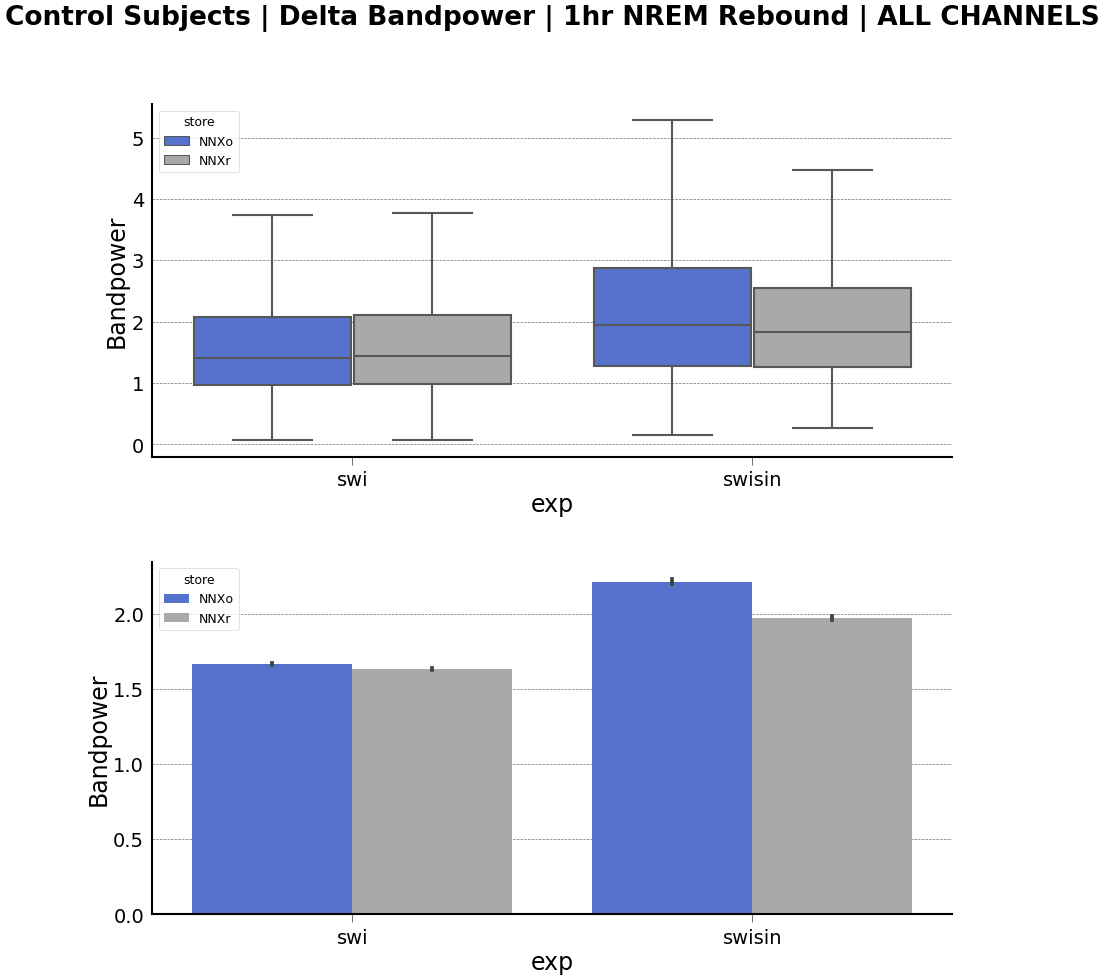

In [223]:
f, ax = plt.subplots(2, 1, figsize=(20, 20))

sns.boxplot(data=ctrl.exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], showfliers=False, ax=ax[0])
sns.barplot(data=ctrl.exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], ax=ax[1])

f.suptitle('Control Subjects | Delta Bandpower | 1hr NREM Rebound | ALL CHANNELS')

Text(0.5, 0.98, 'ACR Subjects | Delta Bandpower | 1hr NREM Rebound | ALL CHANNELS')

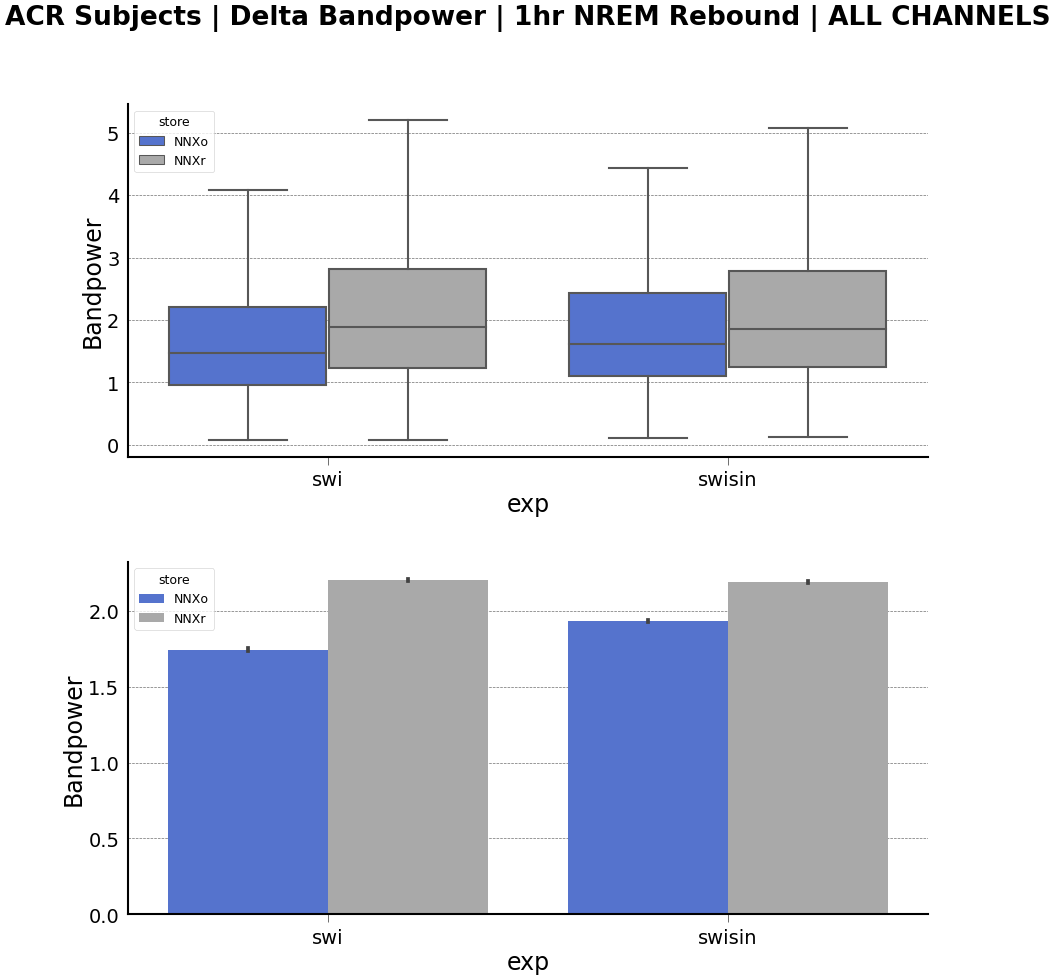

In [224]:
f, ax = plt.subplots(2, 1, figsize=(20, 20))

sns.boxplot(data=gtacr.exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], showfliers=False, ax=ax[0])
sns.barplot(data=gtacr.exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], ax=ax[1])

f.suptitle('ACR Subjects | Delta Bandpower | 1hr NREM Rebound | ALL CHANNELS')

Text(0.5, 0.98, 'SOM-ChR2 Subjects | Delta Bandpower | 1hr NREM Rebound | ALL CHANNELS')

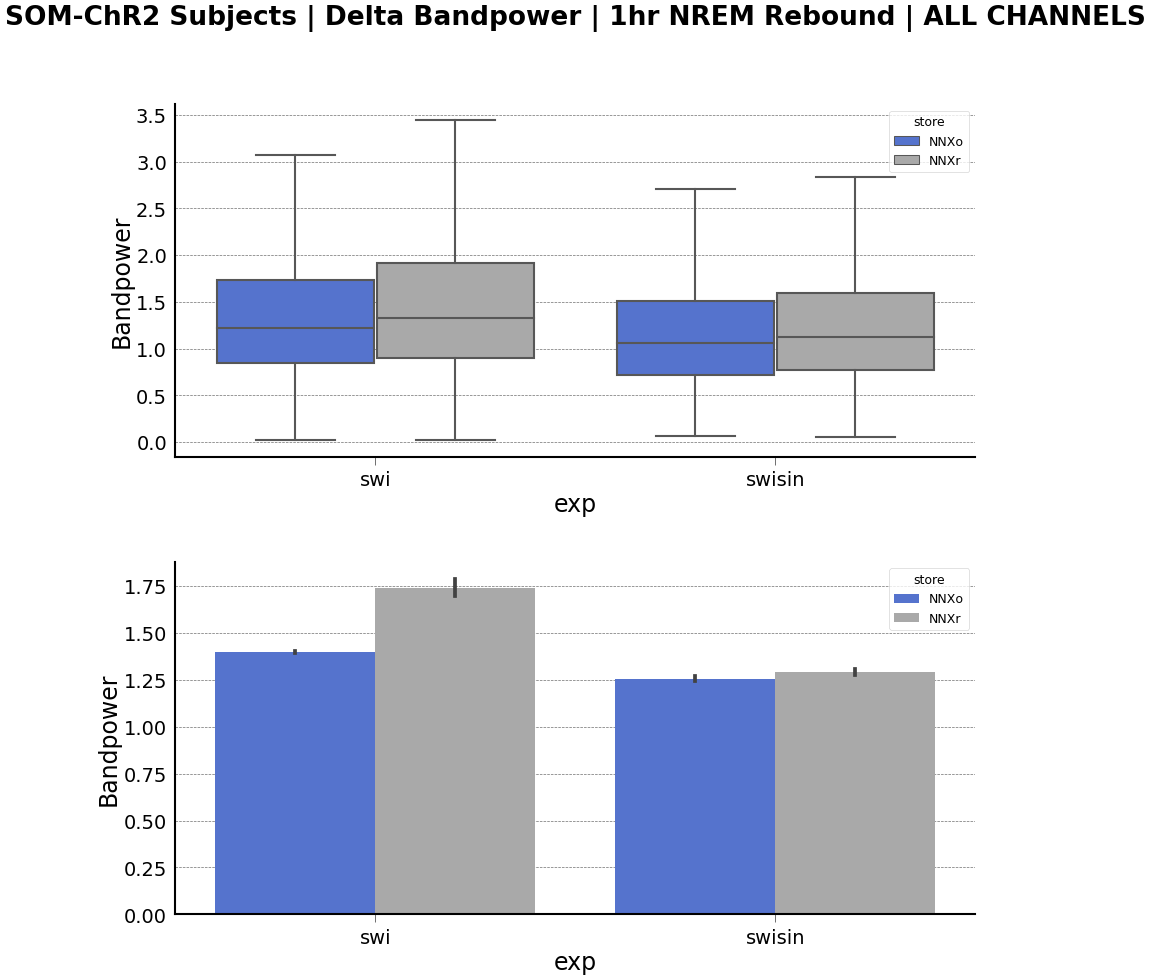

In [225]:
f, ax = plt.subplots(2, 1, figsize=(20, 20))

sns.boxplot(data=som.exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], showfliers=False, ax=ax[0])
sns.barplot(data=som.exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], ax=ax[1])

f.suptitle('SOM-ChR2 Subjects | Delta Bandpower | 1hr NREM Rebound | ALL CHANNELS')

# Histology based

In [245]:
# convert all layers to strings
rdf.layer = rdf.layer.astype(str)

In [247]:
rdf['pure_chan'] = 'N/A'
rdf['histo_based'] = 'N/A'

In [248]:
rdf.loc[rdf['channel'] <= 8, 'pure_chan'] = 'lower'
rdf.loc[rdf['channel'] >= 9, 'pure_chan'] = 'upper'

In [250]:
rdf.loc[rdf.layer.isin(['0', '1', '2/3']), 'histo_based'] = 'superficial'
#rdf.loc[rdf.layer.isin(['4']), 'histo_based'] = 'middle'
rdf.loc[rdf.layer.isin(['5', '6a']), 'histo_based'] = 'deep'

In [251]:
ctrl = rdf.loc[rdf.exp_type=='control'].loc[rdf.Band=='delta']
gtacr = rdf.loc[rdf.exp_type=='exp'].loc[rdf.Band=='delta']
#gtacr = gtacr.loc[gtacr.subject != 'ACR_14']
som = rdf.loc[rdf.exp_type=='som'].loc[rdf.Band=='delta']

Text(0.5, 0.98, 'ACR Subjects | Delta Bandpower | 1hr NREM Rebound')

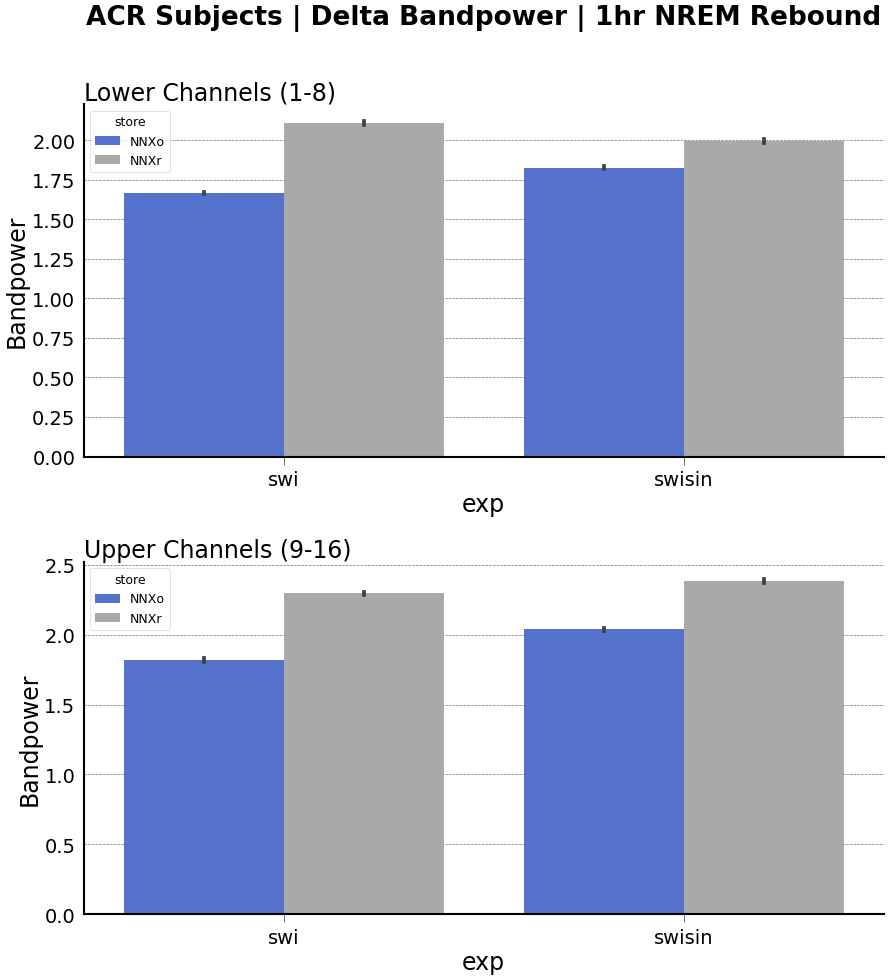

In [254]:
f, ax = plt.subplots(2, 1, figsize=(20, 20))

sns.barplot(data=gtacr.loc[gtacr.pure_chan=='lower'].exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], ax=ax[0])
ax[0].set_title('Lower Channels (1-8)')
sns.barplot(data=gtacr.loc[gtacr.pure_chan=='upper'].exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], ax=ax[1])
ax[1].set_title('Upper Channels (9-16)')

f.suptitle('ACR Subjects | Delta Bandpower | 1hr NREM Rebound')

Text(0.5, 0.98, 'ACR Subjects | Delta Bandpower | 1hr NREM Rebound')

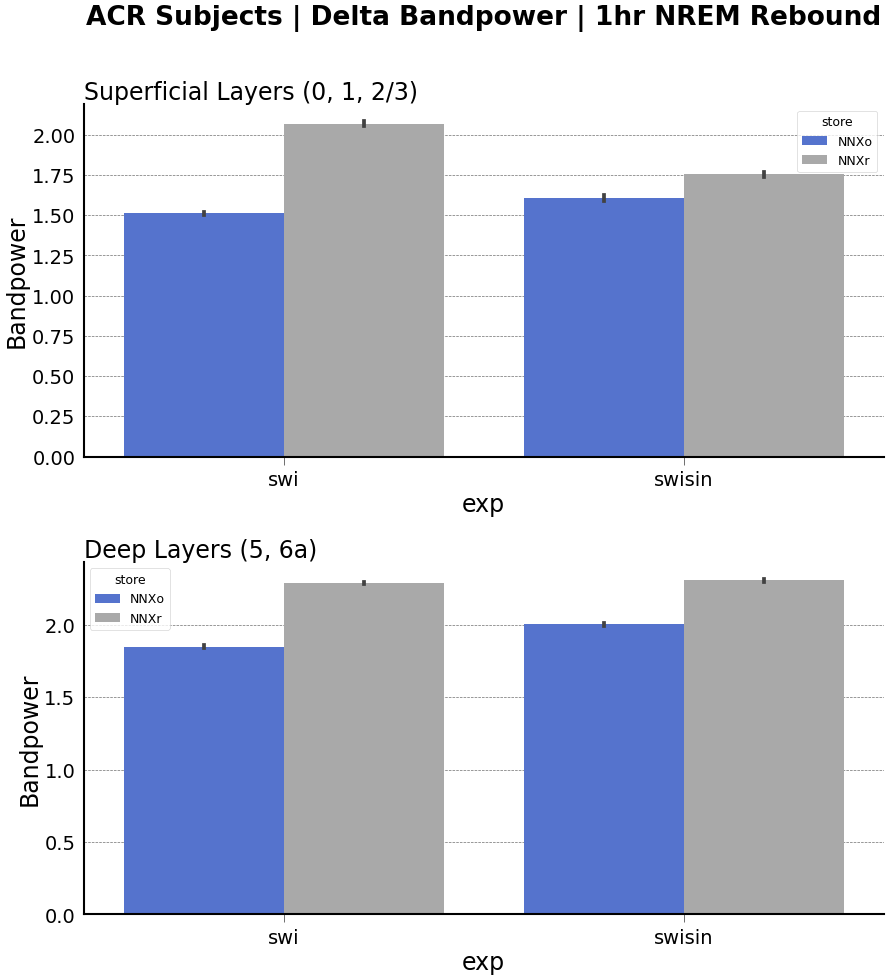

In [255]:
f, ax = plt.subplots(2, 1, figsize=(20, 20))

sns.barplot(data=gtacr.loc[gtacr.histo_based=='superficial'].exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], ax=ax[0])
ax[0].set_title('Superficial Layers (0, 1, 2/3)')
sns.barplot(data=gtacr.loc[gtacr.histo_based=='deep'].exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], ax=ax[1])
ax[1].set_title('Deep Layers (5, 6a)')

f.suptitle('ACR Subjects | Delta Bandpower | 1hr NREM Rebound')

Text(0.5, 0.98, 'SOM-ChR2 Subjects | Delta Bandpower | 1hr NREM Rebound')

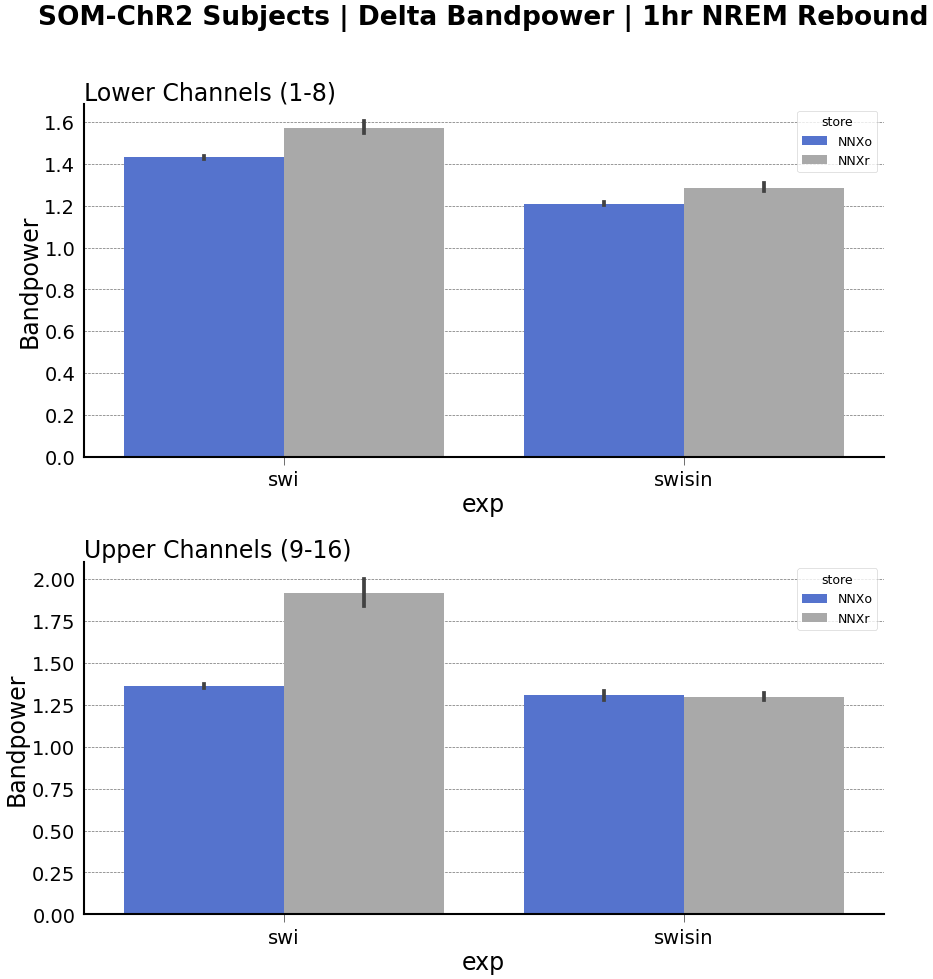

In [257]:
f, ax = plt.subplots(2, 1, figsize=(20, 20))

sns.barplot(data=som.loc[som.pure_chan=='lower'].exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], ax=ax[0])
ax[0].set_title('Lower Channels (1-8)')
sns.barplot(data=som.loc[som.pure_chan=='upper'].exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], ax=ax[1])
ax[1].set_title('Upper Channels (9-16)')

f.suptitle('SOM-ChR2 Subjects | Delta Bandpower | 1hr NREM Rebound')

Text(0.5, 0.98, 'SOM-ChR2 Subjects | Delta Bandpower | 1hr NREM Rebound')

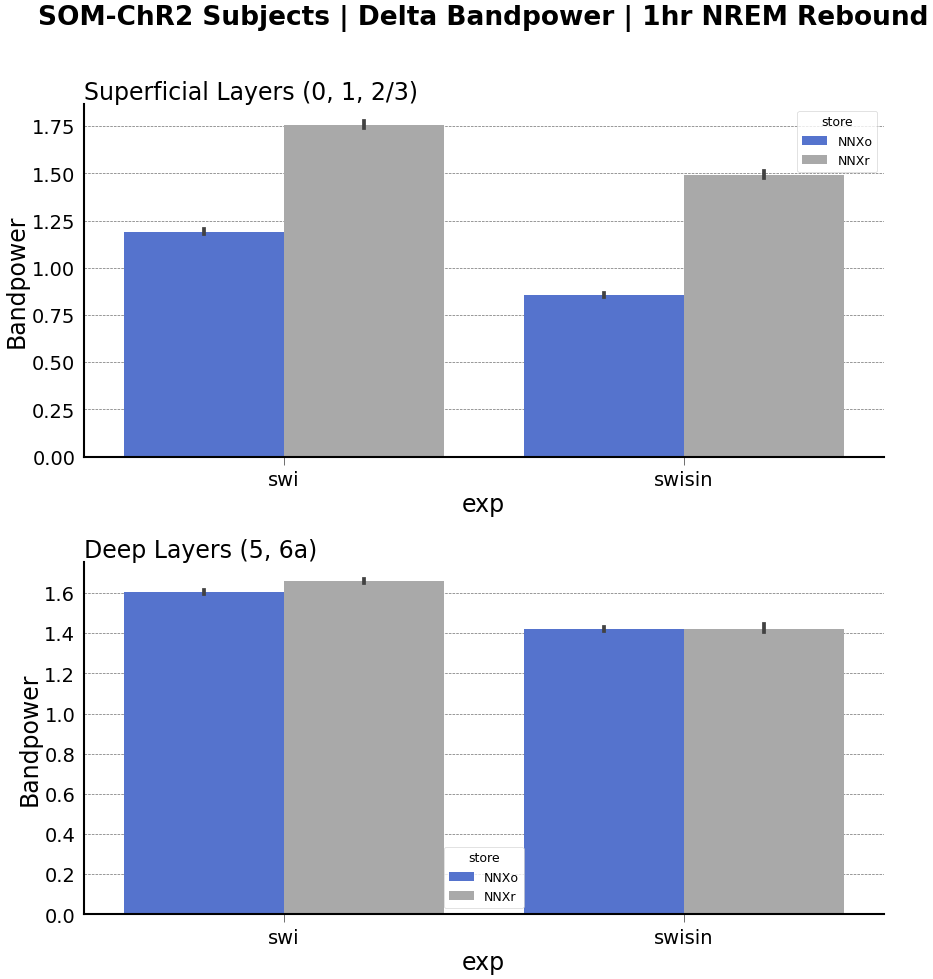

In [256]:
f, ax = plt.subplots(2, 1, figsize=(20, 20))

sns.barplot(data=som.loc[som.histo_based=='superficial'].exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], ax=ax[0])
ax[0].set_title('Superficial Layers (0, 1, 2/3)')
sns.barplot(data=som.loc[som.histo_based=='deep'].exp_names(), x='exp', y='Bandpower', hue='store', palette=['royalblue', 'darkgrey'], hue_order=['NNXo', 'NNXr'], ax=ax[1])
ax[1].set_title('Deep Layers (5, 6a)')

f.suptitle('SOM-ChR2 Subjects | Delta Bandpower | 1hr NREM Rebound')

In [263]:
new_rdf = rdf.loc[rdf.Band=='delta'].groupby(['subject', 'exp', 'layer', 'store']).Bandpower.median().to_frame().reset_index()
new_rdf['diff'] = new_rdf.groupby(['subject', 'exp', 'layer'])['Bandpower'].diff().fillna(0)

In [296]:
histo_diffs = new_rdf.loc[new_rdf['diff'] != 0]
# invert the diff column
histo_diffs['diff'] = histo_diffs['diff'] * -1

<Axes: xlabel='subject', ylabel='diff'>

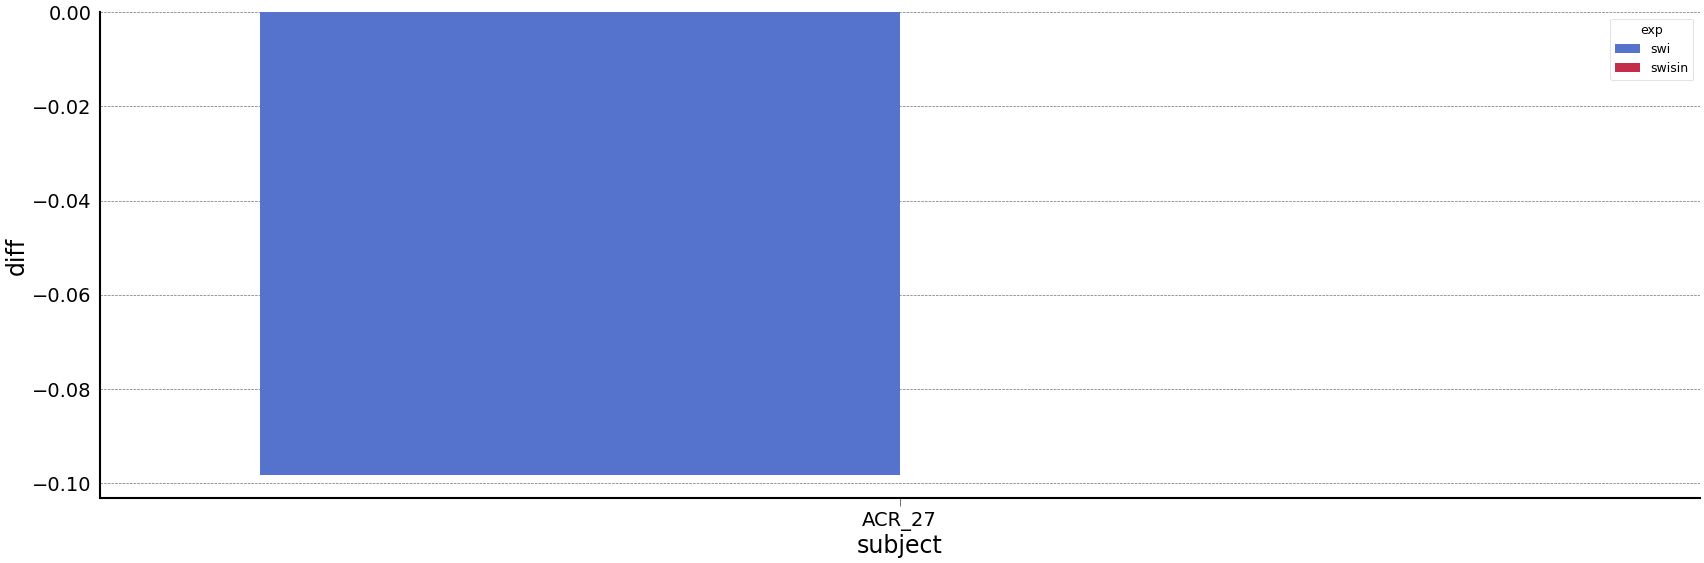

In [306]:
sns.barplot(data=histo_diffs.loc[histo_diffs.layer.isin(['1'])].exp_names(), x='subject', y='diff', hue='exp', palette=['royalblue', 'crimson'], hue_order=['swi', 'swisin'])

<Axes: xlabel='subject', ylabel='diff'>

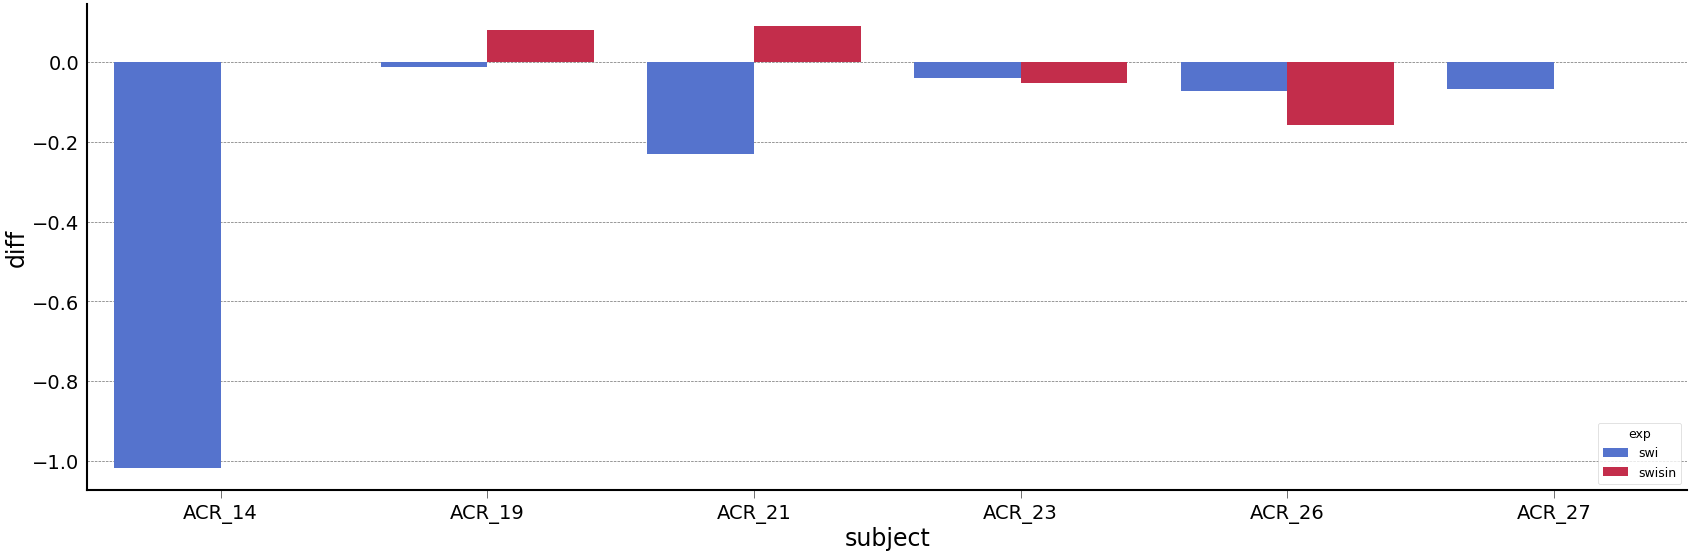

In [307]:
sns.barplot(data=histo_diffs.loc[histo_diffs.layer.isin(['2/3'])].exp_names(), x='subject', y='diff', hue='exp', palette=['royalblue', 'crimson'], hue_order=['swi', 'swisin'])

<Axes: xlabel='subject', ylabel='diff'>

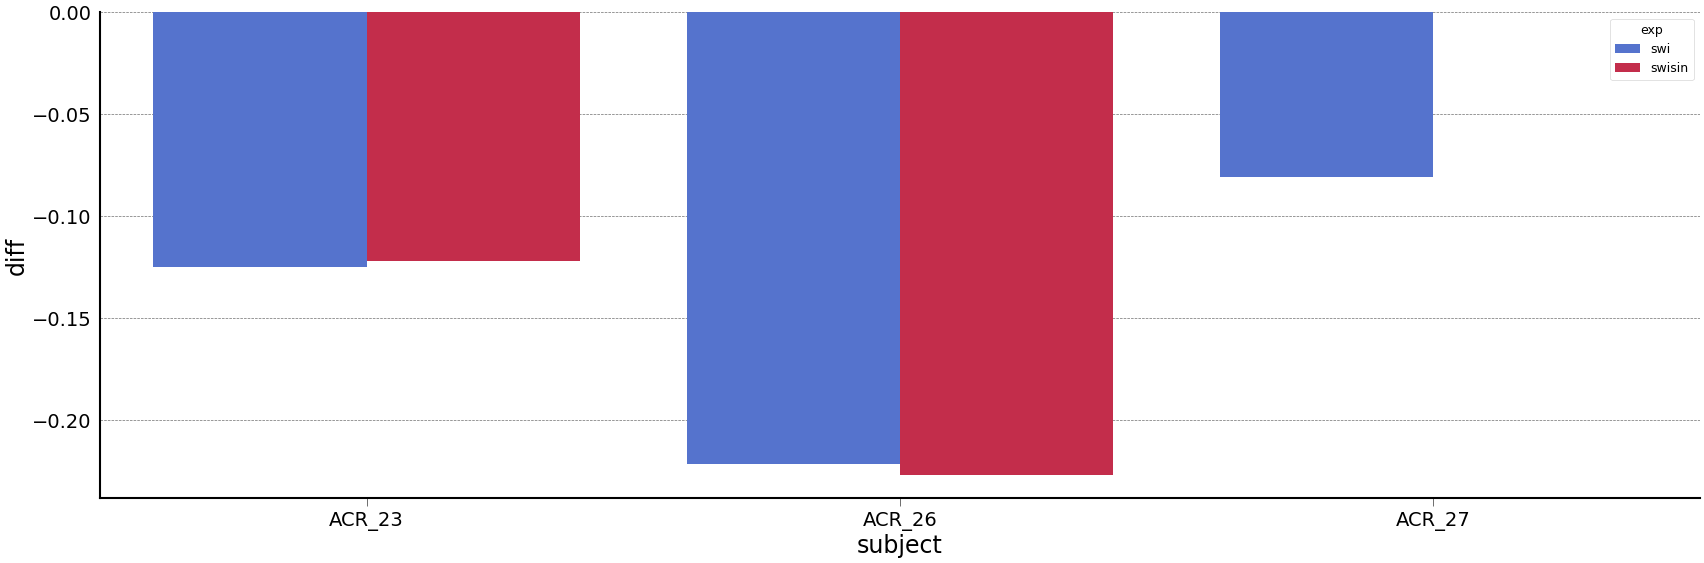

In [308]:
sns.barplot(data=histo_diffs.loc[histo_diffs.layer.isin(['4'])].exp_names(), x='subject', y='diff', hue='exp', palette=['royalblue', 'crimson'], hue_order=['swi', 'swisin'])

<Axes: xlabel='subject', ylabel='diff'>

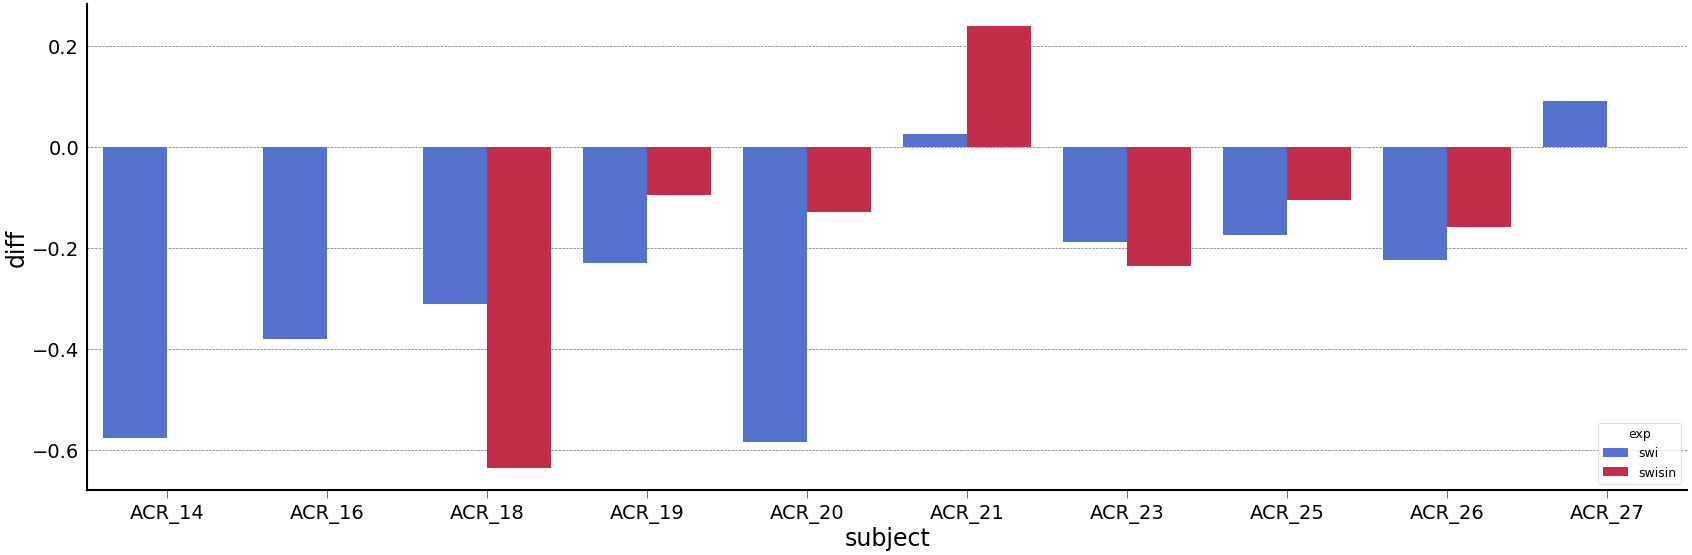

In [309]:
sns.barplot(data=histo_diffs.loc[histo_diffs.layer.isin(['5'])].exp_names(), x='subject', y='diff', hue='exp', palette=['royalblue', 'crimson'], hue_order=['swi', 'swisin'])

<Axes: xlabel='subject', ylabel='diff'>

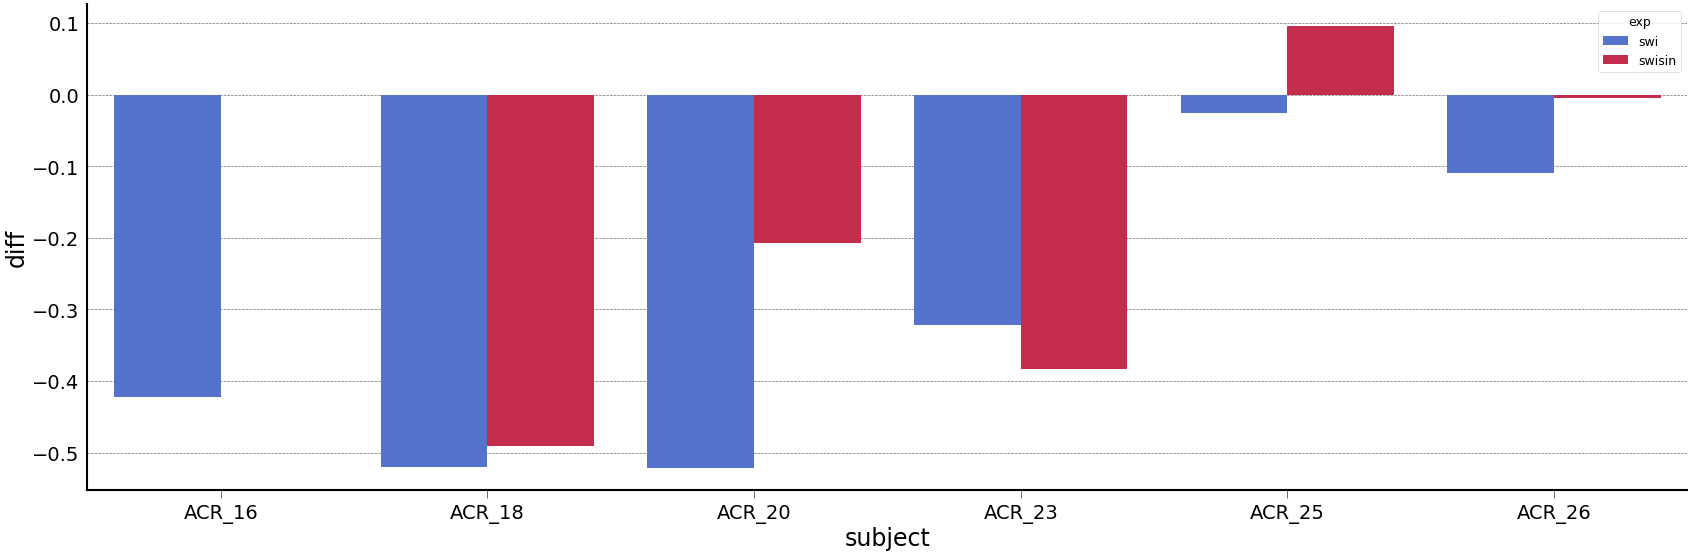

In [310]:
sns.barplot(data=histo_diffs.loc[histo_diffs.layer.isin(['6a'])].exp_names(), x='subject', y='diff', hue='exp', palette=['royalblue', 'crimson'], hue_order=['swi', 'swisin'])

# SWI ONLY

In [316]:
swa = rdf.loc[rdf.Band=='delta']

In [322]:
control_means = swa.prb('NNXr').groupby(['subject', 'exp', 'channel']).Bandpower.mean().to_frame().reset_index()

In [327]:
control_means.sbj('ACR_14').chnl(1).loc[control_means.exp=='swi']['Bandpower'].values[0]

2.1485885021054725

In [318]:
swa_op = swa.prb('NNXo')

In [329]:
op_rel = swa_op.sbj('ACR_14').loc[swa_op.exp=='swi'].loc[swa_op.channel==1]['Bandpower'].values / control_means.sbj('ACR_14').chnl(1).loc[control_means.exp=='swi']['Bandpower'].values[0]

In [330]:
swa_op.sbj('ACR_14').loc[swa_op.exp=='swi'].loc[swa_op.channel==1, 'Bandpower'] = op_rel 

In [339]:
swa_op.groupby(['subject', 'exp', 'channel'])['Bandpower']/control_means['Bandpower'].values

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (313, 2) + inhomogeneous part.

In [340]:
swa_14 = swa.loc[swa.subject=='ACR_14']

,datetime,channel,store,state,Band,Bandpower,region,exp_type,subject,exp,layer,pure_chan,histo_based
518689,2022-10-07 14:37:47.917119,1,NNXo,NREM,delta,1.786793,frontal,exp,ACR_14,swi,2/3,lower,superficial
518691,2022-10-07 14:37:49.915967,1,NNXo,NREM,delta,1.648709,frontal,exp,ACR_14,swi,2/3,lower,superficial
518693,2022-10-07 14:37:51.914815,1,NNXo,NREM,delta,3.347247,frontal,exp,ACR_14,swi,2/3,lower,superficial
518695,2022-10-07 14:37:53.913663,1,NNXo,NREM,delta,1.408695,frontal,exp,ACR_14,swi,2/3,lower,superficial
518697,2022-10-07 14:37:55.912511,1,NNXo,NREM,delta,1.824977,frontal,exp,ACR_14,swi,2/3,lower,superficial
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11760809,2023-11-10 15:14:45.225471,12,NNXo,NREM,delta,0.246620,parietal,som,ACR_28,swisin,nan,upper,N/A
11760811,2023-11-10 15:14:45.225471,13,NNXo,NREM,delta,0.238290,parietal,som,ACR_28,swisin,nan,upper,N/A
11760813,2023-11-10 15:14:45.225471,14,NNXo,NREM,delta,0.253075,parietal,som,ACR_28,swisin,nan,upper,N/A
11760815,2023-11-10 15:14:45.225471,15,NNXo,NREM,delta,0.273273,parietal,som,ACR_28,swisin,nan,upper,N/A
